# Tutorial 4 - Single-cell RNA-Seq Analysis for Zebrafish

## Overview

This code sets up a workflow for processing and analyzing single-cell RNA-Seq (scRNA-Seq) data, from Gimenez G, Antony J, Horsfield J study, using the Seurat package in R. The steps include data preparation, quality control, normalization, and clustering. The workflow begins with downloading raw sequencing data, organizing it, and creating a Seurat object for analysis. It then proceeds with identifying important features like highly variable genes, performing dimensionality reduction, and clustering cells based on their gene expression patterns.

Also the code provide plots to visualize and interpret scRNA-seq data. Violin plots and Feature Scatter plots assess the quality control metrics, such as gene counts and mitochondrial content. The Highly Variable Genes plot highlights genes driving differences across cells. Dimensionality reduction techniques, such as PCA, UMAP, and t-SNE, are used to visualize cell groupings and explore the overall structure of the data. Heatmaps display gene expression patterns across clusters, while the Elbow plot helps determine the optimal number of principal components for clustering. Together, these plots provide a comprehensive overview of data quality, cell clustering, and marker gene expression.

## STEP 1. Getting Started

This step sets up the R enviroment for the scRNA-seq analysis installing the R/Seurat package along with the dependencies, and ensuring the necessary libraries for this analysis. This step can take over 35 minutes to run.

<div class="alert alert-block alert-warning"> NOTE: This Jupyter Notebook was developed to run within a customized container on AWS with all software and packages pre-configured. If running without this customized container, you will need to install tools using the Miniforge environment setup instructions below before moving on to Step 2.</div>

In [ ]:
# Enter commands in R (or R studio, if installed)
install.packages('Seurat')

In [ ]:
setRepositories(ind = 1:3, addURLs = c('https://satijalab.r-universe.dev', 'https://bnprks.r-universe.dev/'))
install.packages(c("BPCells", "presto", "glmGamPoi"))

In [ ]:
#install.packages("fastmap")
#install.packages("shiny")

In [ ]:
# Install packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("patchwork", "ggplot2", "cowplot", "dplyr", "fastmap"), force = TRUE)

In [ ]:
# Install the remotes package
if (!requireNamespace("remotes", quietly = TRUE)) {
  install.packages("remotes")
}
install.packages('Signac')
remotes::install_github("satijalab/seurat-data", quiet = TRUE)
remotes::install_github("satijalab/azimuth", quiet = TRUE)
remotes::install_github("satijalab/seurat-wrappers", quiet = TRUE)

In [1]:
# Load Seurat library for scRNA-seq analysis
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(cowplot)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




Create necessary directories to store data

In [5]:
dir.create("data", recursive = TRUE)
dir.create("data/raw_data")
dir.create("data/seurat_output")

## STEP 2. Experimental Design / Dataset

This step downloading and preparing the raw scRNA-seq data from the GEO database GSE275537. The code first download 10x Genomics scRNA-seq data for further analysis by Seurat. It downloads the data, organizes it into a Seurat-compatible format, and loads it for downstream processing and renames the extracted files to match Seurat's expected file naming conventions. 

In [6]:
# Download the supplementary data (TAR file) from GEO
system("wget -O data/raw_data/GSE275537_RAW.tar 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE275nnn/GSE275537/suppl/GSE275537_RAW.tar'")

In [8]:
# Extract the TAR file
system("tar -xvf data/raw_data/GSE275537_RAW.tar -C data/raw_data")

# Create the GSM8479117 directory if it doesn't exist
dir.create("data/raw_data/GSM8479117", recursive = TRUE)

# Rename the extracted GSM8479117 files to match Seurat's expected names
system("mv data/raw_data/GSM8479117_WT_rep1_barcodes.tsv.gz data/raw_data/GSM8479117/barcodes.tsv.gz")
system("mv data/raw_data/GSM8479117_WT_rep1_features.tsv.gz data/raw_data/GSM8479117/features.tsv.gz")
system("mv data/raw_data/GSM8479117_WT_rep1_matrix.mtx.gz data/raw_data/GSM8479117/matrix.mtx.gz")

Warning message in dir.create("data/raw_data/GSM8479117", recursive = TRUE):
“'data/raw_data/GSM8479117' already exists”


Once the raw data is organized into the correct format, it is loaded into R using the Read10X function, which is designed to read gene expression matrices generated by 10X Genomics. This function reads three essential files—barcodes, features (genes), and the expression matrix (counts)—and organizes them into a format suitable for further analysis.

Next, the CreateSeuratObject function is used to convert this data into a Seurat object, which is the core data structure for scRNA-seq analysis in Seurat. This object stores the gene expression data alongside associated metadata. 

In [9]:
# Load data
data_dir <- "data/raw_data/GSM8479117"
scrna.data  <- Read10X(data.dir = data_dir)

# Create a Seurat object
scrna <- CreateSeuratObject(counts = scrna.data, project = "Zebrafish_scRNA", min.cells = 3, min.features = 200)
scrna

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
18704 features across 11506 samples within 1 assay 
Active assay: RNA (18704 features, 0 variable features)
 1 layer present: counts

## STEP 3. Quality Control, Filtering, and Normalization

This step performs quality control on the scRNA-seq data by calculating the percentage of mitochondrial gene expression, visualizing key metrics such as gene counts, RNA counts, and mitochondrial content using violin and scatter plots, filtering cells based on these metrics to remove low-quality cells, and normalizing the gene expression data to prepare it for further analysis.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


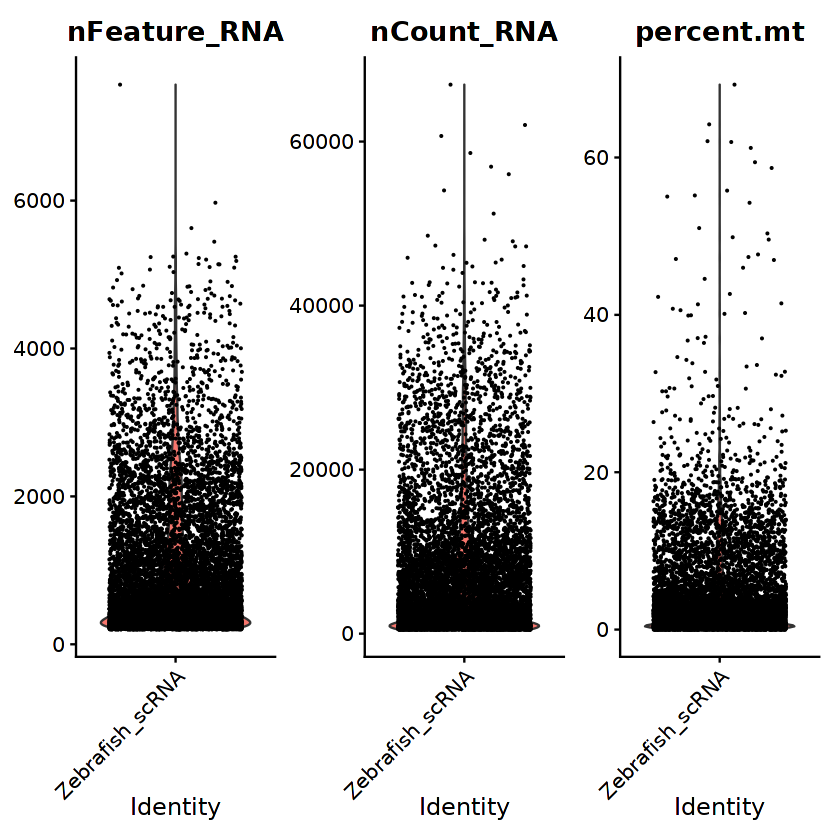

Normalizing layer: counts



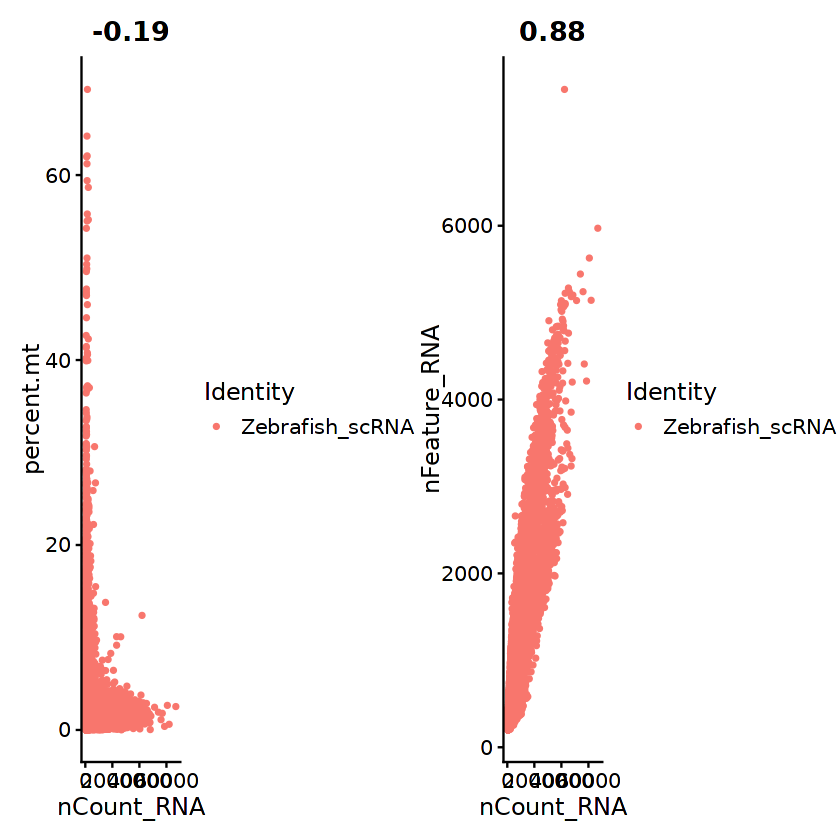

In [10]:
# Quality control
scrna[["percent.mt"]] <- PercentageFeatureSet(scrna, pattern = "^mt-")

# Plot QC metrics
VlnPlot(scrna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(scrna, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(scrna, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

# Filter cells based on QC metrics
scrna <- subset(scrna, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# Normalize the data
scrna <- NormalizeData(scrna, normalization.method = "LogNormalize", scale.factor = 10000)


## STEP 4. Identifying Highly Variable Genes

This step identifies the top 2,000 highly variable genes in the scRNA-seq dataset using the variance-stabilizing transformation (VST) method, which highlights genes that show significant variability across cells, often indicative of biological differences. It then plots these variable genes using the VariableFeaturePlot, and labels the top 10 most variable genes in the dataset, providing a visual representation of genes that are likely to contribute to key cell distinctions.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


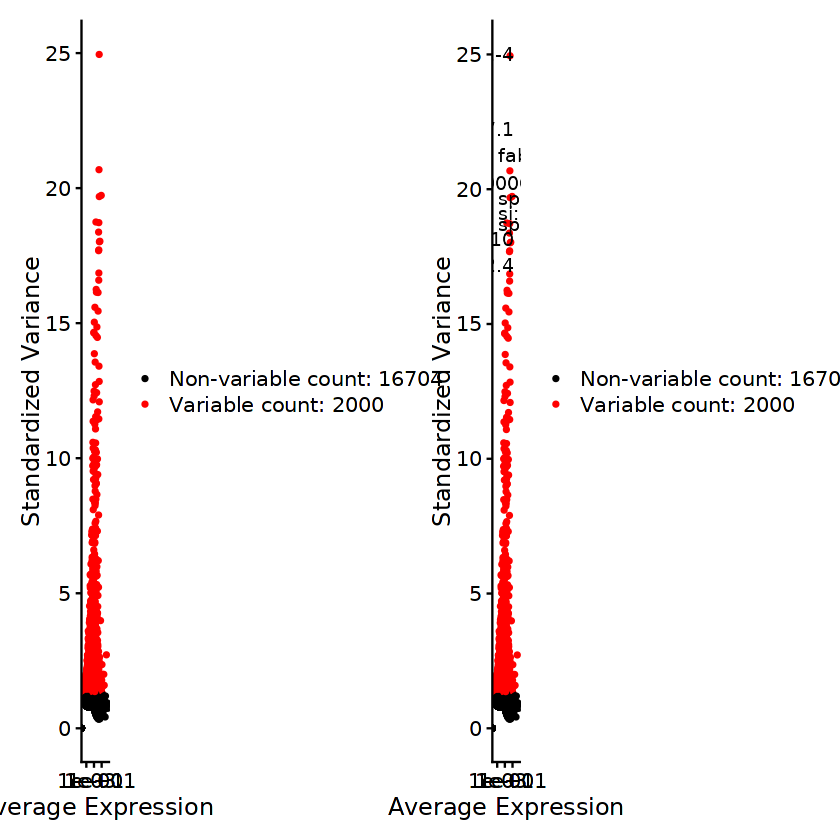

In [11]:
# Identify highly variable genes
scrna <- FindVariableFeatures(scrna, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(scrna), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(scrna)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

## STEP 5. Labeling Cell Types

This step scales the gene expression data for all genes in the dataset, ensuring that each gene contributes equally to the analysis. PCA is then run using only the previously identified highly variable genes to reduce the dimensionality of the data, capturing the most important sources of variation. The VizDimLoadings function visualizes the contribution of individual genes to the first two principal components, helping identify which genes drive the most variability in the dataset.

Centering and scaling data matrix

PC_ 1 
Positive:  hbaa2, si:ch211-103n10.5, si:ch1073-184j22.1, TCIM (1 of many), lect2l, igfbp1a, klf17, alox5b.3, BX908782.2, prdx2 
	   hsc70, znfl2a, hmbsb, hdr, npsn, si:ch1073-429i10.1, tal1, cpa5, si:dkey-188i13.9, cd151 
	   s100a10a, cnot6l, hmbsa, ch25hl2, sult2st1, mpx, gapdh, abcc13, hbae5, sms 
Negative:  c1qb, c1qc, grna, c1qa, si:dkey-5n18.1, havcr1, ctss2.2, ms4a17a.10, si:ch211-194m7.3, marco 
	   lgals2a, si:ch211-147m6.1, slc3a2a, ctsba, mfap4, mafba, cfp, ctsc, psap, MFAP4 (1 of many) 
	   itgae.1, si:ch211-283g2.2, zgc:174904, id1, slc22a21, lygl1, selenop, aplp2, CU929150.1, ctsa 
PC_ 2 
Positive:  si:dkey-203a12.4, spink2.5, si:dkey-203a12.2, si:dkey-77g12.4, hbaa2, si:dkey-203a12.7, si:zfos-2330d3.7.1, spink2.3, si:dkey-203a12.5, si:ch211-14a17.10 
	   spink2.4, si:ch1073-110a20.2, zmp:0000001323, si:dkeyp-75b4.10, BX322787.1, FO904885.1, spink2.2, CABZ01058647.1, si:ch211-194m7.8, si:ch1073-376c22.1 
	   itln1, MFAP4 (1 of man

PC_ 1 
Positive:  hbaa2, si:ch211-103n10.5, si:ch1073-184j22.1, TCIM (1 of many), lect2l, igfbp1a, klf17, alox5b.3, BX908782.2, prdx2 
Negative:  c1qb, c1qc, grna, c1qa, si:dkey-5n18.1, havcr1, ctss2.2, ms4a17a.10, si:ch211-194m7.3, marco 
PC_ 2 
Positive:  si:dkey-203a12.4, spink2.5, si:dkey-203a12.2, si:dkey-77g12.4, hbaa2, si:dkey-203a12.7, si:zfos-2330d3.7.1, spink2.3, si:dkey-203a12.5, si:ch211-14a17.10 
Negative:  mki67, top2a, CABZ01058261.1, cenpf, dlgap5, smc2, nusap1, tpx2, zgc:110425, ncapd2 
PC_ 3 
Positive:  hbaa2, si:ch211-103n10.5, CR936442.1, si:ch1073-184j22.1, CU571382.1, TCIM (1 of many), ctsla, igic1s1, zgc:194275, igl4v8 
Negative:  si:dkey-77g12.4, spink2.3, si:ch211-14a17.10, si:dkey-203a12.5, si:dkey-203a12.4, si:dkey-203a12.7, spink2.5, si:ch1073-110a20.2, si:ch1073-376c22.1, si:zfos-2330d3.7.1 
PC_ 4 
Positive:  frzb, hoxb8a, admb, cdh16, epcam, areg, fgf23, pcbd1, cort, pcsk2 
Negative:  lect2l, BX908782.2, npsn, c1qc, icn, srgn, c1qa, mpx, si:ch211-147m6.1, 

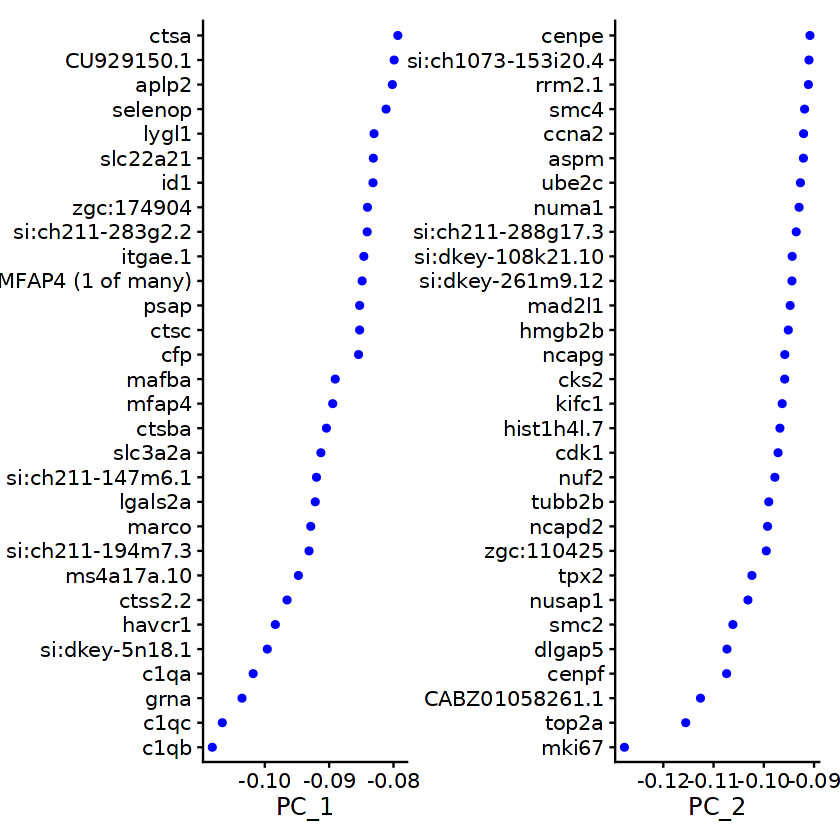

In [12]:
# Run PCA
all.genes <- rownames(scrna)
scrna <- ScaleData(scrna, features = all.genes)
scrna <- RunPCA(scrna, features = VariableFeatures(object = scrna))
# Examine and visualize PCA results a few different ways
print(scrna[["pca"]], dims = 1:5, nfeatures = 10)
VizDimLoadings(scrna, dims = 1:2, reduction = "pca")

## STEP 6. PCA and heatmap plots

This section of the code focuses on clustering and visualizing the scRNA-seq data. First, it generates a PCA plot (DimPlot) to visualize the principal components that summarize the variation across cells. Then, heatmaps are plotted for the top variable genes, showing their expression across cells, followed by an elbow plot to help select the optimal number of principal components (PCs) for downstream analysis.

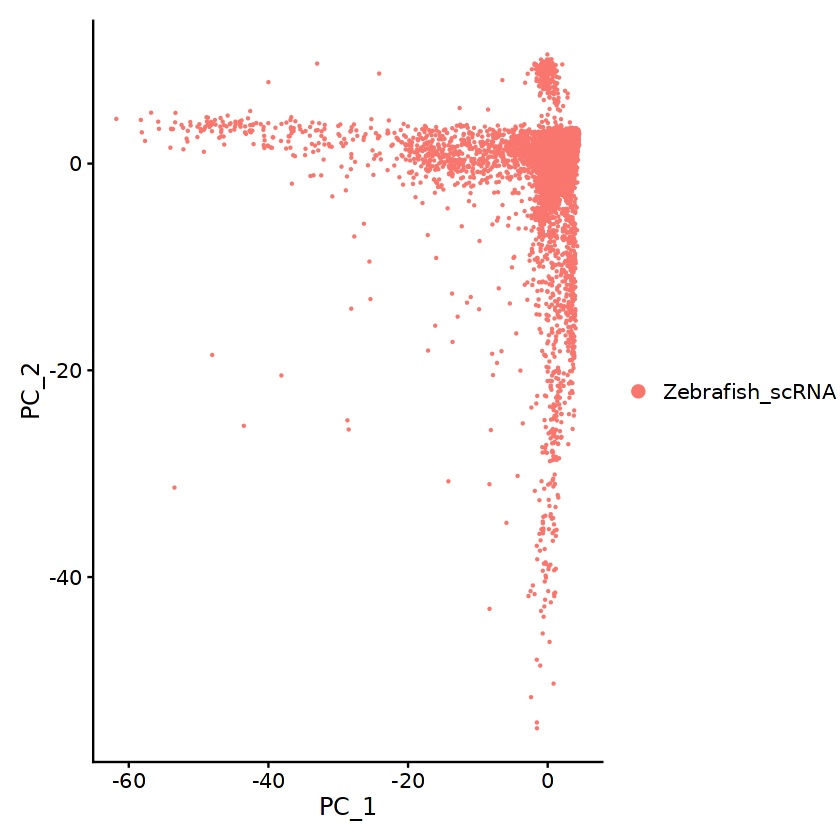

In [13]:
#PCA plot
DimPlot(scrna, reduction = "pca")

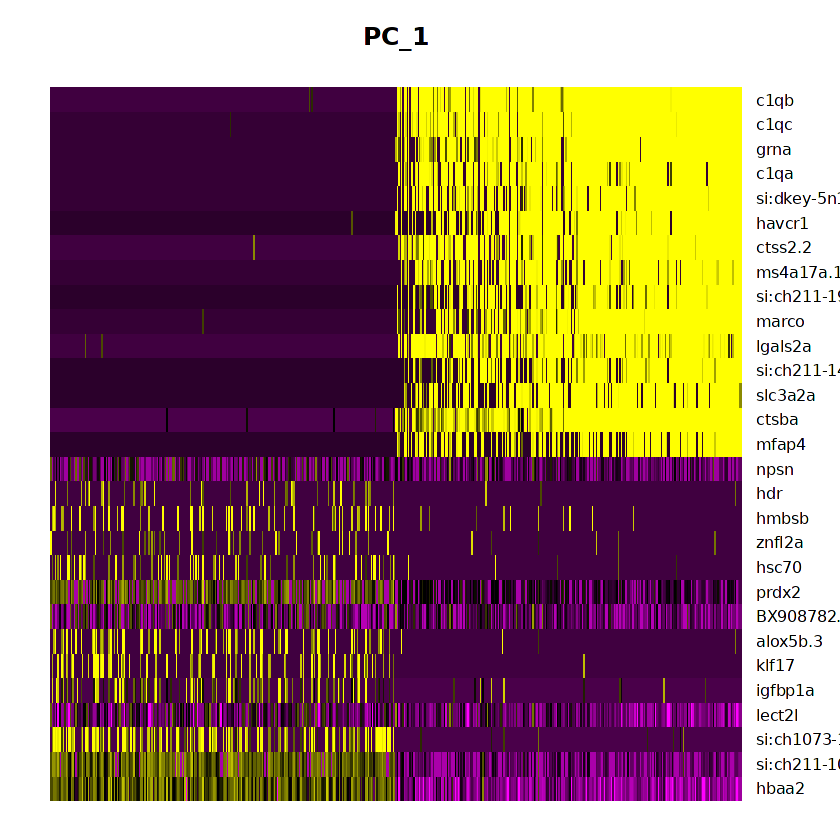

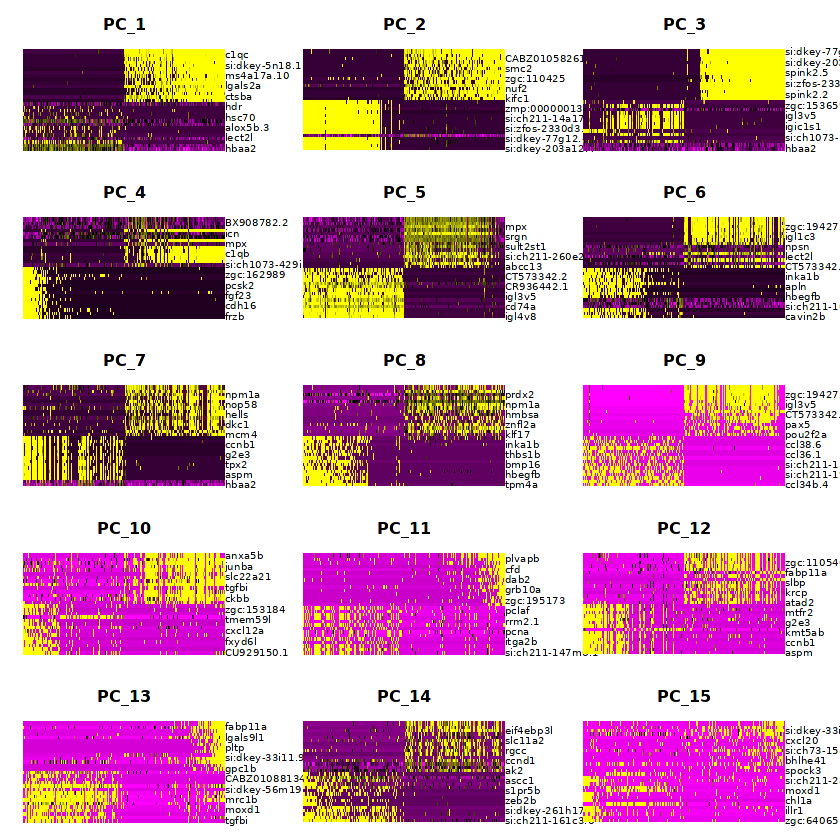

In [14]:
# Heatmap of top variable genes
DimHeatmap(scrna, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(scrna, dims = 1:15, cells = 500, balanced = TRUE)

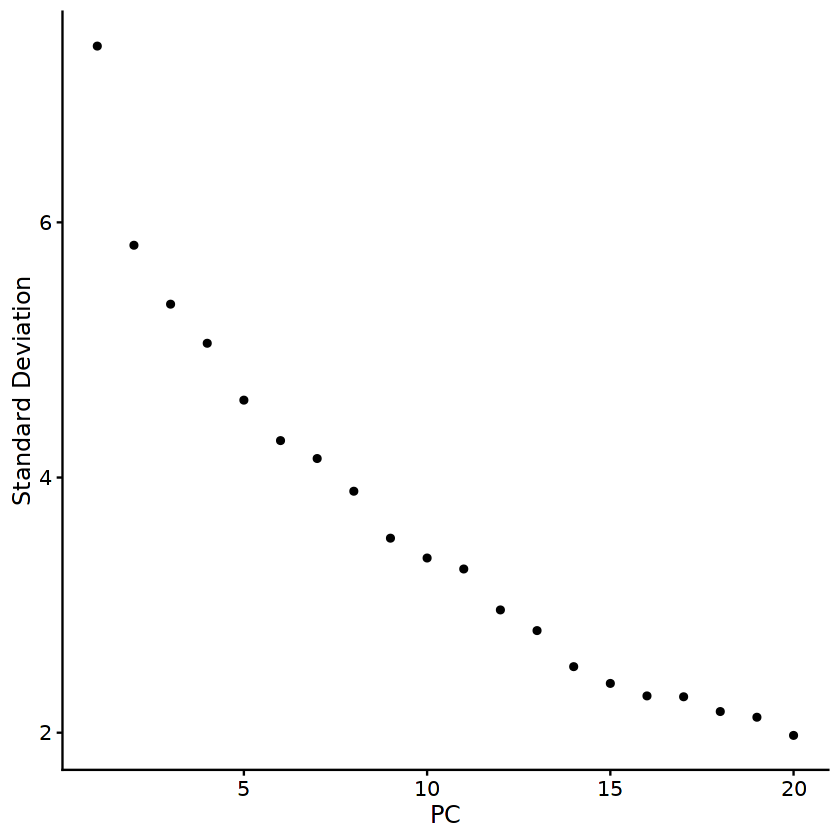

In [15]:
# Elbow plot to determine optimal number of PCs
ElbowPlot(scrna)

## STEP 7. Cluster cells and Run non-linear dimensional reduction (UMAP/tSNE)

Next, the code clusters cells using the Louvain algorithm based on their nearest-neighbor graph, after which the UMAP and t-SNE dimensionality reduction techniques are applied to visualize these clusters. These visualizations, presented in UMAP and t-SNE plots, show cell groupings based on gene expression similarities, providing insight into potential distinct cell populations.

In [16]:
# Identify clusters
scrna <- FindNeighbors(scrna, dims = 1:10)
scrna <- FindClusters(scrna, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8640
Number of edges: 277658

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9273
Number of communities: 16
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:58:53 UMAP embedding parameters a = 0.9922 b = 1.112

15:58:53 Read 8640 rows and found 10 numeric columns

15:58:53 Using Annoy for neighbor search, n_neighbors = 30

15:58:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:58:55 Writing NN index file to temp file /tmp/Rtmp54NCnw/file59594a89e756

15:58:55 Searching Annoy index using 1 thread, search_k = 3000

15:58:58 Annoy recall = 100%

15:58:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

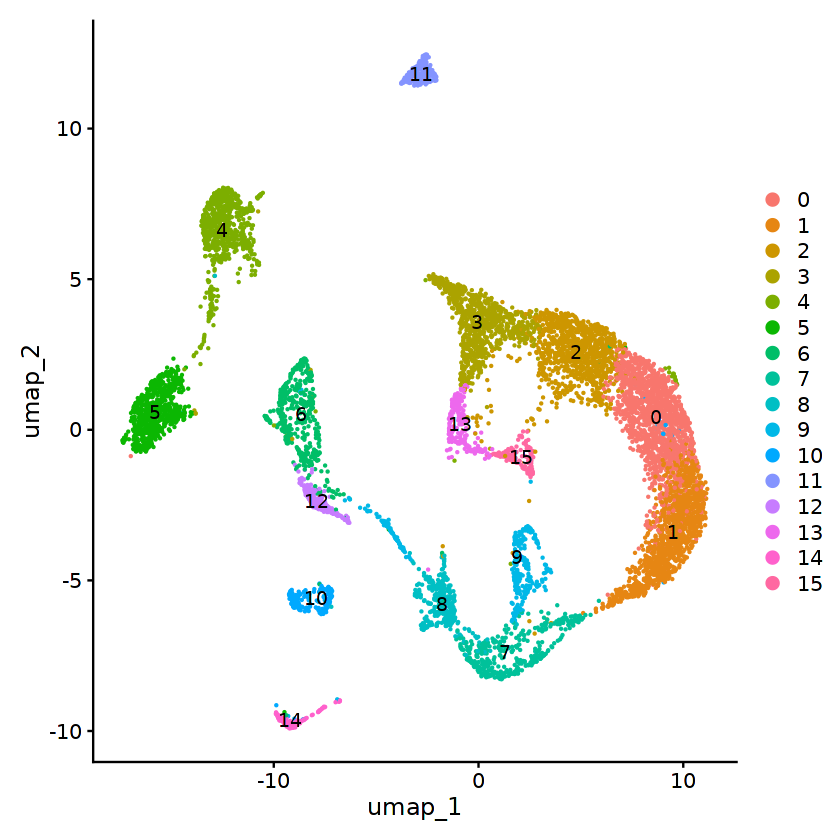

In [17]:
# Run UMAP
scrna <- RunUMAP(scrna, dims = 1:10)
DimPlot(scrna, reduction = "umap", label = TRUE)
saveRDS(scrna, file = "data/seurat_output/scrna_tutorial.rds")

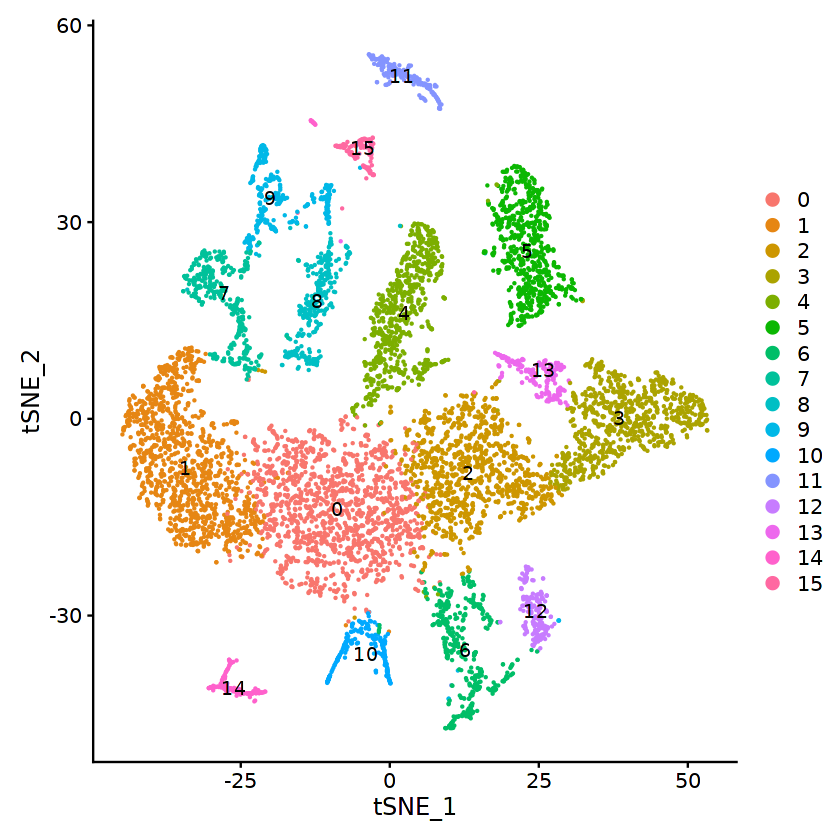

In [18]:
# Run t-SNE
scrna <- RunTSNE(scrna, dims = 1:10)
DimPlot(scrna, reduction = "tsne", label = TRUE)

## STEP 8. Differentially expressed features

This section of the code identifies and visualizes key marker genes for cell clusters in the scRNA-seq data. First, it finds the differentially expressed genes for cluster 2 and then does the same for all clusters, filtering for genes with a log-fold change greater than 1. The code also highlights the markers for specific clusters (e.g., cluster 0) using the ROC method.
Also, Violin plots, feature plots, and a heatmap were used to visualize the gene expression patterns and marker genes across different cell clusters in the scRNA-seq data.

In [19]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(scrna, ident.1 = 2)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lyz,0.000000e+00,1.560659,1.000,1.000,0.000000e+00
lect2l,0.000000e+00,1.468243,0.999,0.971,0.000000e+00
BX908782.2,6.266234e-271,1.411501,0.976,0.788,1.172036e-266
npsn,4.569349e-216,1.066840,0.946,0.710,8.546511e-212
srgn,3.662294e-205,1.227981,0.944,0.748,6.849954e-201


In [20]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
scrna.markers <- FindAllMarkers(scrna, only.pos = TRUE)
scrna.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

write.csv(scrna.markers, "data/seurat_output/cluster_markers.csv", row.names = FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,3.582848,0.843,0.307,0.000000e+00,0,si:ch211-250g4.3
0.000000e+00,1.229525,1.000,1.000,0.000000e+00,0,hbaa1
1.120916e-300,1.106875,1.000,1.000,2.096560e-296,0,hbba1.1
7.923030e-287,1.046558,1.000,1.000,1.481924e-282,0,hbba1
3.393083e-82,3.063304,0.367,0.192,6.346423e-78,0,nt5c2l1
4.195606e-70,3.833204,0.228,0.086,7.847461e-66,0,gp9
1.224102e-69,3.410006,0.182,0.054,2.289561e-65,0,si:dkey-188i13.9
1.733290e-65,3.070537,0.340,0.189,3.241945e-61,0,mibp
1.271590e-48,1.066854,0.551,0.417,2.378382e-44,0,hemgn


In [21]:
cluster0.markers <- FindMarkers(scrna, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)
head(cluster0.markers, 10)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
si:ch211-250g4.3,0.870,2.2512567,0.740,3.5828480,0.843,0.307
hbaa1,0.813,0.8509092,0.626,1.2295254,1.000,1.000
hbba1.1,0.808,0.7663686,0.616,1.1068753,1.000,1.000
hbba1,0.800,0.7237425,0.600,1.0465584,1.000,1.000
si:ch211-5k11.8,0.781,0.6761288,0.562,0.9766789,1.000,1.000
rplp0,0.719,0.5023111,0.438,0.7335539,0.996,0.993
CR383676.2,0.692,0.2916103,0.384,0.4223469,0.985,0.946
fth1a,0.675,0.4341072,0.350,0.6512448,0.871,0.843
uqcrb,0.380,0.1367072,0.240,0.2946259,0.176,0.472


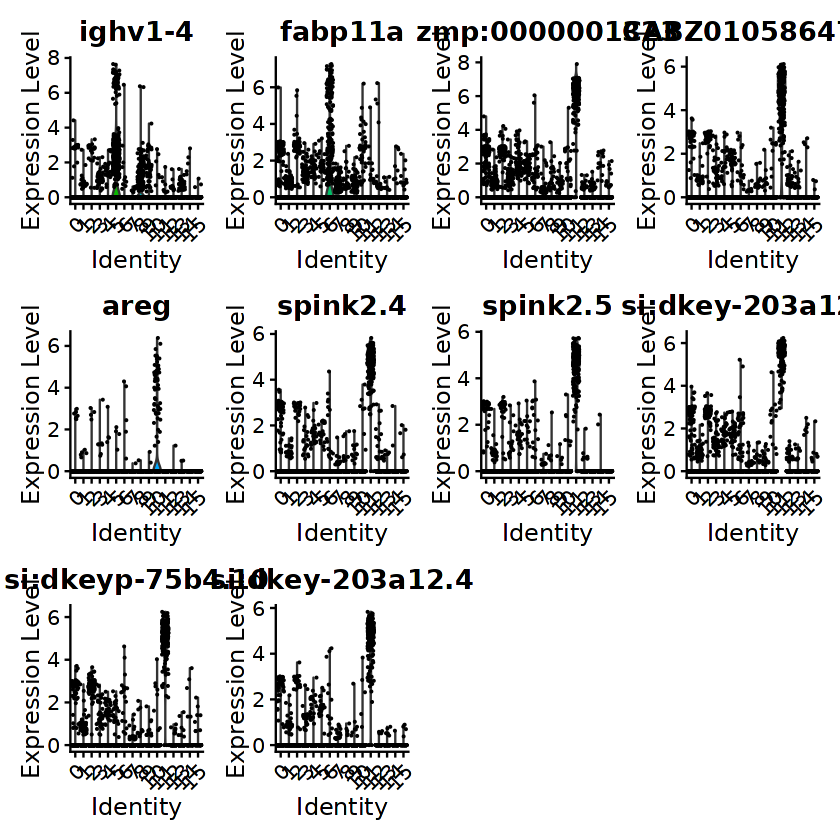

In [22]:
# Assuming you have identified highly variable genes using FindVariableFeatures
top_genes <- head(VariableFeatures(scrna), 10)  # Get top 10 highly variable genes
VlnPlot(scrna, features = top_genes)

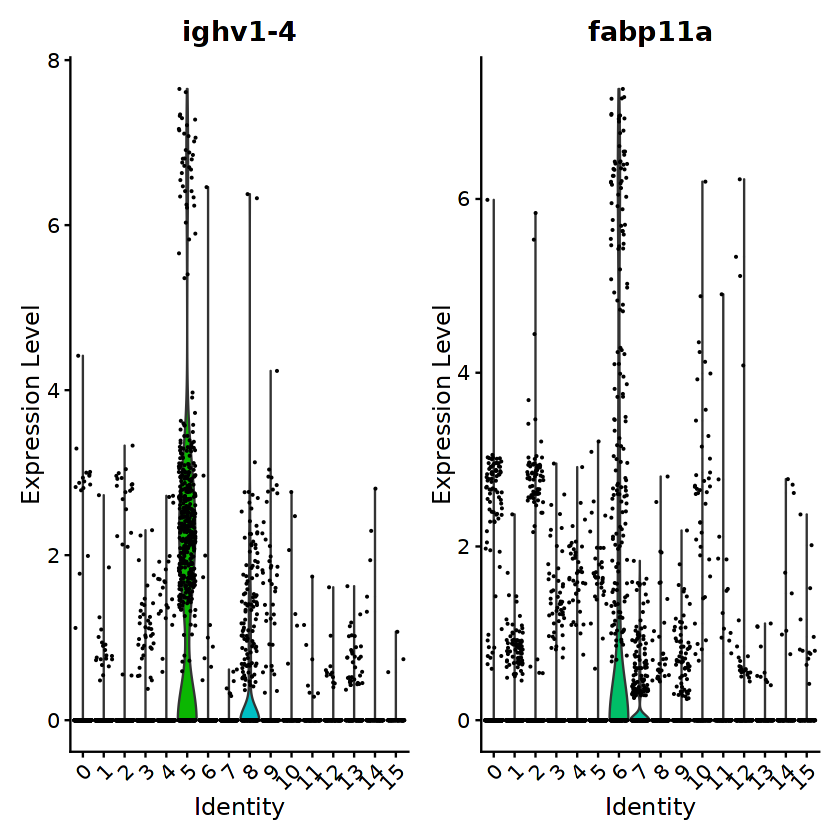

In [24]:
# Violin Plot
VlnPlot(scrna, features = c("ighv1-4", "fabp11a"))

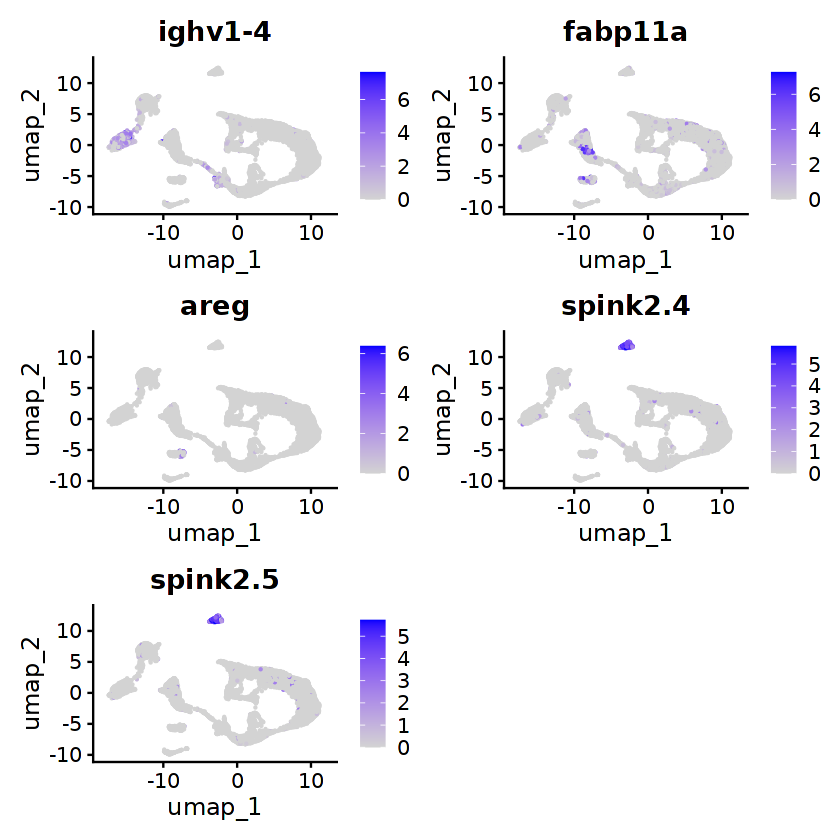

In [26]:
FeaturePlot(scrna, features = c("ighv1-4", "fabp11a", "areg", "spink2.4", "spink2.5"))

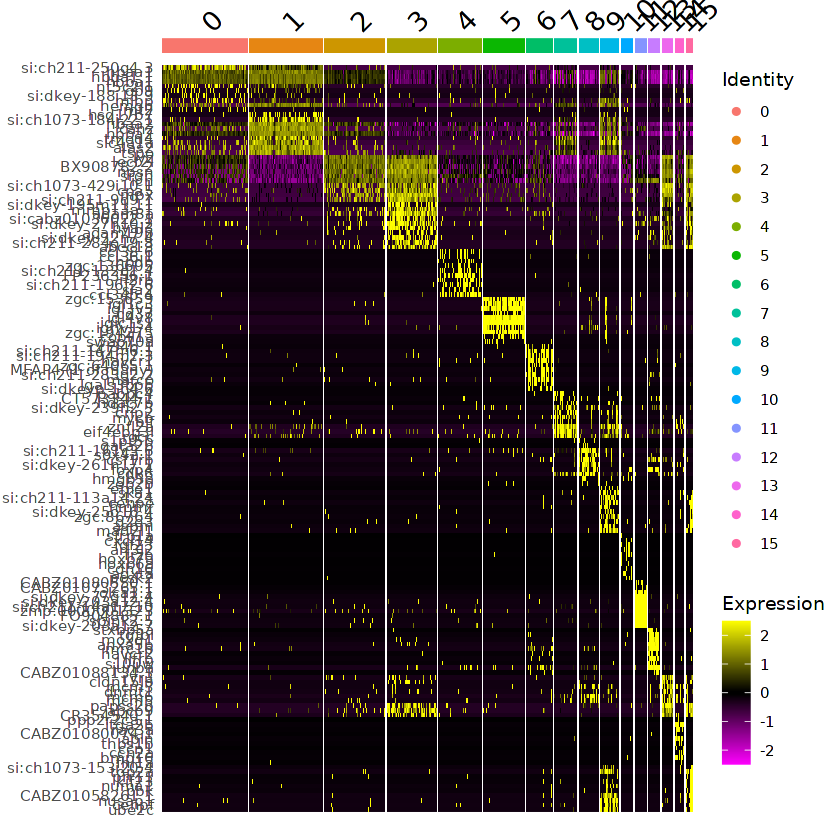

In [27]:
scrna.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(scrna, features = top10$gene)

## STEP 9. Assigning cell type identity to clusters

This section of the code renames the cell clusters with more meaningful biological identities, based on prior knowledge of the cell types. It uses the RenameIdents function to assign these names to the identified clusters.

Next, it creates a UMAP (Uniform Manifold Approximation and Projection) plot, which visualizes the clusters of cells in two dimensions, with labels for each cluster. The plot is customized with larger labels and axes using ggplot2 for clear visualization. The final UMAP plot is then saved as a JPEG image file (scrna3k_umap.jpg), showing the distinct cell populations with their assigned identities in the scRNA-seq dataset.

In [28]:
new.cluster.ids <- c("Prolif", "Neurons", "Prolif", "Neuro Dev", "OPCs", "Neurogenesis", 
    "Erythro", "Mitosis", "ECM", "Neuro Sign", "Microglia")
names(new.cluster.ids) <- levels(scrna)
scrna <- RenameIdents(scrna, new.cluster.ids)
DimPlot(scrna, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

ERROR: Error in names(new.cluster.ids) <- levels(scrna): 'names' attribute [16] must be the same length as the vector [11]


In [ ]:
library(ggplot2)
plot <- DimPlot(scrna, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") +
    theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + guides(colour = guide_legend(override.aes = list(size = 10)))
ggsave(filename = "data/seurat_output/scrna3k_umap.jpg", height = 7, width = 12, plot = plot, quality = 50)

In [ ]:
saveRDS(scrna, file = "data/seurat_output/scrna3k_final.rds")
